In [1]:
import os

# Directories - change based on where your project is saved
project_dir = "/content/drive/MyDrive/CS2822_Final_Project"
models_dir = os.path.join(project_dir, "Models")
datasets_dir = os.path.join(project_dir, "Datasets")
RESULTS_DIR = os.path.join(project_dir, "Results")
MODEL_NAME = "resnet18.a1_in1k"

# CHANGE THESE
normal_model_name = "o2o_medium_resnet18.a1-e=2-lr=0.01_limit=20.pt"
bugged_model_name = "buggy_o2o_easy_resnet18.a1-e=2-lr=0.01_limit=20.pt"
concept_instance_name = "CRAFT_12_3_24_Corgi_Snow_320_im_12_concepts"

In [2]:
# Mount google drive to local dir
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Experiments
- This is where we will carry out our experiment:
    - How can we detect the difference between a model with spurious correlations and a regular (non-spurious) model? Using only:
        - Concepts,
        -  their activation vectors,
        - and their importances

Below is the sekeleton of the experiment:

# Load Dependencies

In [3]:
import argparse

import torch
import torch.optim as optim
from torch import nn
from torch.nn import Module
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm
from tqdm.auto import tqdm
import timm
import wandb
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from einops import rearrange
from scipy.optimize import minimize


# 0. Spawrious Source Code

In [4]:
import os
import tarfile
import urllib
import urllib.request
from typing import Any, Tuple

import torch
from PIL import Image
from torch.utils.data import ConcatDataset, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import timm
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# MODEL_NAME = "vit_so400m_patch14_siglip_384"
# MODEL_NAME = 'swin_base_patch4_window7_224.ms_in22k_ft_in1k'
# MODEL_NAME = 'deit3_base_patch16_224.fb_in22k_ft_in1k'
# MODEL_NAME = 'beit_base_patch16_224.in22k_ft_in22k_in1k'
# MODEL_NAME = 'eva02_base_patch14_448.mim_in22k_ft_in22k_in1k'
# MODEL_NAME = 'levit_128s.fb_dist_in1k'

def set_model_name(name):
    global MODEL_NAME
    MODEL_NAME = name


def _extract_dataset_from_tar(
    tar_file_name: str, data_dir: str
) -> None:
    tar_file_dst = os.path.join(data_dir, tar_file_name)
    print("Extracting dataset...")
    tar = tarfile.open(tar_file_dst, "r:gz")
    tar.extractall(os.path.dirname(tar_file_dst))
    tar.close()


def _download_dataset_if_not_available(
    dataset_name: str, data_dir: str, remove_tar_after_extracting: bool = True
) -> None:
    """
    datasets.txt file, which is present in the data_dir, is used to check if the dataset is already extracted. If the dataset is already extracted, then the tar file is not downloaded again.
    """
    data_dir = data_dir.split("/spawrious224/")[
        0
    ]  # in case people pass in the wrong root_dir
    os.makedirs(data_dir, exist_ok=True)
    dataset_name = dataset_name.lower()
    if dataset_name.split("_")[0] == "m2m":
        dataset_name = "entire_dataset"
    url_dict = {
        "entire_dataset": "https://www.dropbox.com/s/hofkueo8qvaqlp3/spawrious224__entire_dataset.tar.gz?dl=1",
        "o2o_easy": "https://www.dropbox.com/s/kwhiv60ihxe3owy/spawrious224__o2o_easy.tar.gz?dl=1",
        "o2o_medium": "https://www.dropbox.com/s/x03gkhdwar5kht4/spawrious224__o2o_medium.tar.gz?dl=1",
        "o2o_hard": "https://www.dropbox.com/s/p1ry121m2gjj158/spawrious224__o2o_hard.tar.gz?dl=1",
        # "m2m": "https://www.dropbox.com/s/5usem63nfub266y/spawrious__m2m.tar.gz?dl=1",
    }
    tar_file_name = f"spawrious224__{dataset_name}.tar.gz"
    tar_file_dst = os.path.join(data_dir, tar_file_name)
    url = url_dict[dataset_name]

    # check if the dataset is already extracted
    if _check_images_availability(data_dir, dataset_name):
        print("Dataset already downloaded and extracted.")
        return
    # check if the tar file is already downloaded
    else:
        if os.path.exists(tar_file_dst):
            print("Dataset already downloaded. Extracting...")
            _extract_dataset_from_tar(
                tar_file_name, data_dir
            )
            return
        # download the tar file and extract from it
        else:
            print("Dataset not found. Downloading...")
            response = urllib.request.urlopen(url)
            total_size = int(response.headers.get("Content-Length", 0))
            block_size = 1024
            # Track progress of download
            progress_bar = tqdm(total=total_size, unit="iB", unit_scale=True)
            with open(tar_file_dst, "wb") as f:
                while True:
                    buffer = response.read(block_size)
                    if not buffer:
                        break
                    f.write(buffer)
                    progress_bar.update(len(buffer))
            progress_bar.close()
            print("Dataset downloaded. Extracting...")
            _extract_dataset_from_tar(
                tar_file_name, data_dir
            )
            return


class CustomImageFolder(Dataset):
    """
    A class that takes one folder at a time and loads a set number of images in a folder and assigns them a specific class
    """

    def __init__(
        self, folder_path, class_index, location_index, limit=None, transform=None
    ):
        self.folder_path = folder_path
        self.class_index = class_index
        self.location_index = location_index
        self.image_paths = [
            os.path.join(folder_path, img)
            for img in os.listdir(folder_path)
            if img.endswith((".png", ".jpg", ".jpeg"))
        ]
        if limit:
            self.image_paths = self.image_paths[:limit]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index: int) -> Tuple[Any, Any, Any]:
        img_path = self.image_paths[index]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        class_label = torch.tensor(self.class_index, dtype=torch.long)
        location_label = torch.tensor(self.location_index, dtype=torch.long)
        return img, class_label, location_label


class MultipleDomainDataset:
    N_STEPS = 5001  # Default, subclasses may override
    CHECKPOINT_FREQ = 100  # Default, subclasses may override
    N_WORKERS = 8  # Default, subclasses may override
    ENVIRONMENTS = None  # Subclasses should override
    INPUT_SHAPE = None  # Subclasses should override

    def __getitem__(self, index):
        return self.datasets[index]

    def __len__(self):
        return len(self.datasets)


def build_combination(benchmark_type, group, test, filler=None):
    total = 3168
    combinations = {}
    if "m2m" in benchmark_type:
        counts = [total, total]
        combinations["train_combinations"] = {
            ("bulldog",): [(group[0], counts[0]), (group[1], counts[1])],
            ("dachshund",): [(group[1], counts[0]), (group[0], counts[1])],
            ("labrador",): [(group[2], counts[0]), (group[3], counts[1])],
            ("corgi",): [(group[3], counts[0]), (group[2], counts[1])],
        }
        combinations["test_combinations"] = {
            ("bulldog",): [test[0], test[1]],
            ("dachshund",): [test[1], test[0]],
            ("labrador",): [test[2], test[3]],
            ("corgi",): [test[3], test[2]],
        }
    else:
        counts = [int(0.97 * total), int(0.87 * total)]
        combinations["train_combinations"] = {
            ("bulldog",): [(group[0], counts[0]), (group[0], counts[1])],
            ("dachshund",): [(group[1], counts[0]), (group[1], counts[1])],
            ("labrador",): [(group[2], counts[0]), (group[2], counts[1])],
            ("corgi",): [(group[3], counts[0]), (group[3], counts[1])],
            ("bulldog", "dachshund", "labrador", "corgi"): [
                (filler, total - counts[0]),
                (filler, total - counts[1]),
            ],
        }
        combinations["test_combinations"] = {
            ("bulldog",): [test[0], test[0]],
            ("dachshund",): [test[1], test[1]],
            ("labrador",): [test[2], test[2]],
            ("corgi",): [test[3], test[3]],
        }
    return combinations


def _get_combinations(benchmark_type: str) -> Tuple[dict, dict]:
    combinations = {
        "o2o_easy": (
            ["desert", "jungle", "dirt", "snow"],
            ["dirt", "snow", "desert", "jungle"],
            "beach",
        ),
        "o2o_medium": (
            ["mountain", "beach", "dirt", "jungle"],
            ["jungle", "dirt", "beach", "snow"],
            "desert",
        ),
        "o2o_hard": (
            ["jungle", "mountain", "snow", "desert"],
            ["mountain", "snow", "desert", "jungle"],
            "beach",
        ),
        "m2m_hard": (
            ["dirt", "jungle", "snow", "beach"],
            ["snow", "beach", "dirt", "jungle"],
            None,
        ),
        "m2m_easy": (
            ["desert", "mountain", "dirt", "jungle"],
            ["dirt", "jungle", "mountain", "desert"],
            None,
        ),
        "m2m_medium": (
            ["beach", "snow", "mountain", "desert"],
            ["desert", "mountain", "beach", "snow"],
            None,
        ),
    }
    if benchmark_type not in combinations:
        raise ValueError("Invalid benchmark type")
    group, test, filler = combinations[benchmark_type]
    return build_combination(benchmark_type, group, test, filler)


class SpawriousBenchmark(MultipleDomainDataset):
    ENVIRONMENTS = ["Test", "SC_group_1", "SC_group_2"]
    input_shape = (3, 224, 224)
    num_classes = 4
    class_list = ["bulldog", "corgi", "dachshund", "labrador"]
    locations_list = ["desert", "jungle", "dirt", "mountain", "snow", "beach"]

    def __init__(self, benchmark, root_dir, augment=True):
        combinations = _get_combinations(benchmark.lower())
        self.type1 = benchmark.lower().startswith("o2o")
        train_datasets, test_datasets = self._prepare_data_lists(
            combinations["train_combinations"],
            combinations["test_combinations"],
            root_dir,
            augment,
        )
        self.datasets = [ConcatDataset(test_datasets)] + train_datasets

    def get_train_dataset(self):
        return torch.utils.data.ConcatDataset(self.datasets[1:])

    def get_test_dataset(self):
        return self.datasets[0]

    # Prepares the train and test data lists by applying the necessary transformations.
    def _prepare_data_lists(
        self, train_combinations, test_combinations, root_dir, augment
    ):
        backbone = timm.create_model(
            # "vit_so400m_patch14_siglip_384",
            MODEL_NAME,
            pretrained=True,
            num_classes=0,
        ).eval()
        self.data_config = timm.data.resolve_model_data_config(backbone)
        test_transforms = timm.data.create_transform(
            **self.data_config, is_training=False
        )

        # test_transforms = transforms.Compose(
        #     [
        #         transforms.Resize((self.input_shape[1], self.input_shape[2])),
        #         transforms.transforms.ToTensor(),
        #         transforms.Normalize(
        #             mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        #         ),
        #     ]
        # )

        if augment:
            train_transforms = timm.data.create_transform(
                **self.data_config, is_training=True
            )
        else:
            train_transforms = test_transforms
        print("Creating Training Dataset:")
        train_data_list = self._create_data_list(
            train_combinations, root_dir, train_transforms
        )
        print("Creating Testing Dataset:")
        test_data_list = self._create_data_list(
            test_combinations, root_dir, test_transforms
        )

        return train_data_list, test_data_list

    # Creates a list of datasets based on the given combinations and transformations.
    def _create_data_list(self, combinations, root_dir, transforms):
        data_list = []
        if isinstance(combinations, dict):
            # Build class groups for a given set of combinations, root directory, and transformations.
            for_each_class_group = []
            cg_index = 0
            for classes, comb_list in combinations.items():
                for_each_class_group.append([])
                for ind, location_limit in enumerate(comb_list):
                    if isinstance(location_limit, tuple):
                        location, limit = location_limit
                    else:
                        location, limit = location_limit, None
                    cg_data_list = []
                    for cls in classes:
                        path = os.path.join(
                            root_dir,
                            "spawrious224",
                            f"{0 if not self.type1 else ind}/{location}/{cls}",
                        )
                        print(f"    Combination: {0 if not self.type1 else ind}/{location}/{cls}")
                        print(f"    Limit: {limit}")
                        data = CustomImageFolder(
                            folder_path=path,
                            class_index=self.class_list.index(cls),
                            location_index=self.locations_list.index(location),
                            limit=limit,
                            transform=transforms,
                        )
                        cg_data_list.append(data)

                    for_each_class_group[cg_index].append(ConcatDataset(cg_data_list))
                cg_index += 1

            for group in range(len(for_each_class_group[0])):
                data_list.append(
                    ConcatDataset(
                        [
                            for_each_class_group[k][group]
                            for k in range(len(for_each_class_group))
                        ]
                    )
                )
        else:
            for location in combinations:
                path = os.path.join(root_dir, f"{0}/{location}/")
                data = ImageFolder(root=path, transform=transforms)
                data_list.append(data)

        return data_list


def _check_images_availability(root_dir: str, dataset_type: str) -> bool:
    # Get the combinations for the given dataset type
    root_dir = root_dir.split("/spawrious224/")[
        0
    ]  # in case people pass in the wrong root_dir
    if dataset_type == "entire_dataset":
        for dataset in ["0", "1", "domain_adaptation_ds"]:
            for location in ["snow", "jungle", "desert", "dirt", "mountain", "beach"]:
                for cls in ["bulldog", "corgi", "dachshund", "labrador"]:
                    path = os.path.join(
                        root_dir, "spawrious224", f"{dataset}/{location}/{cls}"
                    )
                    if not os.path.exists(path) or not any(
                        img.endswith((".png", ".jpg", ".jpeg"))
                        for img in os.listdir(path)
                    ):
                        return False
        return True
    combinations = _get_combinations(dataset_type.lower())

    # Extract the train and test combinations
    train_combinations = combinations["train_combinations"]
    test_combinations = combinations["test_combinations"]

    # Check if the relevant images for each combination are present in the root directory
    for combination in [train_combinations, test_combinations]:
        for classes, comb_list in combination.items():
            for ind, location_limit in enumerate(comb_list):
                if isinstance(location_limit, tuple):
                    location, limit = location_limit
                else:
                    location, limit = location_limit, None

                for cls in classes:
                    path = os.path.join(
                        root_dir,
                        "spawrious224",
                        f"{0 if not dataset_type.lower().startswith('o2o') else ind}/{location}/{cls}",
                    )

                    # If the path does not exist or there are no relevant images, return False
                    if not os.path.exists(path) or not any(
                        img.endswith((".png", ".jpg", ".jpeg"))
                        for img in os.listdir(path)
                    ):
                        return False

    # If all the required images are present, return True
    return True


def get_spawrious_dataset(root_dir: str, dataset_name: str = "entire_dataset"):
    """
    Returns the dataset as a torch dataset, and downloads dataset if dataset is not already available.

    By default, the entire dataset is downloaded, which is necessary for m2m experiments, and domain adaptation experiments
    """
    root_dir = root_dir.split("/spawrious224/")[
        0
    ]  # in case people pass in the wrong root_dir
    assert dataset_name.lower() in {
        "o2o_easy",
        "o2o_medium",
        "o2o_hard",
        "m2m_easy",
        "m2m_medium",
        "m2m_hard",
        "m2m",
        "entire_dataset",
    }, f"Invalid dataset type: {dataset_name}"
    _download_dataset_if_not_available(dataset_name, root_dir)
    # TODO: get m2m to use entire dataset, not half of it
    return SpawriousBenchmark(dataset_name, root_dir, augment=True)

#1. Load Dataset

In [5]:
# Mount google drive to local dir
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Create data dir
!mkdir /content/data

In [7]:
# Set Model Name (using global var)
set_model_name(MODEL_NAME)

import tarfile

def download_dataset(dataset_name):
  # Unzip the  dataset
  drive_dir = os.path.join(datasets_dir, dataset_name)
  !cp $drive_dir /content/data
  tar_file = os.path.join('/content/data', drive_dir.split('/')[-1])
  data_dir = "/content/data/"

  # Extract the dataset
  with tarfile.open(tar_file, 'r:gz') as tar:  # Use 'r' for .tar and 'r:gz' for .tar.gz
      tar.extractall(path=data_dir)

# Download the datasets
download_dataset("1-snow-corgi.tar.gz")
download_dataset("snow_only.tar.gz")
download_dataset("beach_only.tar.gz")

# 2. Download both Models
models are saved to variables 'normal_model' and 'bugged_model'

In [8]:
def load_model(model_name, model_type="resnet18.a1_in1k"):

    checkpoint_path = os.path.join(models_dir, model_name)

    if model_type != "resnet18.a1_in1k":
        print("Only resnet18 is supported currently")
        return

    # Checks if GPU is available first
    if torch.cuda.is_available():
        model_weights = torch.load(os.path.join(models_dir, checkpoint_path))
    else:
        model_weights = torch.load(os.path.join(models_dir, checkpoint_path), map_location=torch.device('cpu'))

    # Create model backbone (base model)
    model = timm.create_model(
                model_type,
                pretrained=True,
                num_classes=4).eval()

    # Load weights
    model.load_state_dict(model_weights)

    # set ENTIRE model to eval mode
    model.eval()

    # Switch weights to cuda if possible
    if torch.cuda.is_available():
        model.to('cuda')

    return model


In [9]:
normal_model = load_model(normal_model_name, "resnet18.a1_in1k")
bugged_model = load_model(bugged_model_name, "resnet18.a1_in1k")

<ipython-input-8-a9afaae834bd>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(os.path.join(models_dir, checkpoint_path))
/usr/local/lib/python3

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

# 3. Download Concepts and importances

In [10]:
# Custom class for storing concept results
class ConceptResults():

    def __init__(self, concept_instance_name):
        concept_results_dir = os.path.join(RESULTS_DIR, concept_instance_name)
        self.concepts = np.load(os.path.join(concept_results_dir, "Concepts.npy"))
        self.importances = np.load(os.path.join(concept_results_dir, "Importances.npy")),
        self.activations = np.load(os.path.join(concept_results_dir, "Activations.npy")),
        self.data_list = torch.load(os.path.join(concept_results_dir, "data_list.pt")),
        self.data_list_no_transforms = torch.load(os.path.join(concept_results_dir, "data_list_no_transforms.pt"))



def load_concept_results(concept_instance_name):
    """Load pre-computed concept results from the results directory"""
    concept_results_dir = os.path.join(RESULTS_DIR, concept_instance_name)

    results = {
        'concepts': np.load(os.path.join(concept_results_dir, "Concepts.npy")),
        'importances': np.load(os.path.join(concept_results_dir, "Importances.npy")),
        'activations': np.load(os.path.join(concept_results_dir, "Activations.npy")),
        'data_list': torch.load(os.path.join(concept_results_dir, "data_list.pt")),
        'data_list_no_transforms': torch.load(os.path.join(concept_results_dir, "data_list_no_transforms.pt"))
    }

    return results


In [11]:
results = ConceptResults(concept_instance_name)

<ipython-input-10-d179618985e1>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data_list = torch.load(os.path.join(concept_results_dir, "data_list.pt")),
<ipython-inp

In [12]:
results.concepts.shape

(12, 512)

# 4. Run Experiments

##CRAFT Visualization Code - From Thomas Fel

In [13]:
import cv2
from skimage import measure
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np


def set_size(w,h):
  """Set matplot figure size"""
  plt.rcParams["figure.figsize"] = [w,h]

def show(img, norm=True, **kwargs):
  """ Display torch/tf tensor """
  if isinstance(img, torch.Tensor):
    img = img.detach().cpu().numpy()
  img = np.array(img, dtype=np.float32)

  # check if channel first
  if img.shape[0] == 1:
    img = img[0]
  if img.shape[0] == 3:
    img = np.moveaxis(img, 0, 2)
  # check if cmap
  if img.shape[-1] == 1:
    img = img[:,:,0]
  # normalize
  if norm:
    img -= img.min(); img/=img.max()

  plt.imshow(img, **kwargs)
  plt.axis('off')
  plt.grid(None)


all_cmaps = []

def get_alpha_cmap(rgb_color):
    # Normalize the RGB color values to the range [0, 1]
    rgb_color = np.array(rgb_color) / 255.0

    # Create an alpha colormap with varying alpha values
    cmap_data = {'red':   [(0, rgb_color[0], rgb_color[0]),
                           (1, rgb_color[0], rgb_color[0])],
                 'green': [(0, rgb_color[1], rgb_color[1]),
                           (1, rgb_color[1], rgb_color[1])],
                 'blue':  [(0, rgb_color[2], rgb_color[2]),
                           (1, rgb_color[2], rgb_color[2])],
                 'alpha': [(0, 0, 0),
                           (1, 1, 1)]}

    alpha_cmap = mcolors.LinearSegmentedColormap('alpha_cmap', cmap_data, N=256)

    all_cmaps.append(alpha_cmap)

    return alpha_cmap

slack_blue  = get_alpha_cmap((54, 197, 240))
slack_green = get_alpha_cmap((46, 182, 125) )
slack_red   = get_alpha_cmap((210, 40, 95))
slack_yellow = get_alpha_cmap((236, 178, 46))
slack_violet = get_alpha_cmap((84, 25, 85))

google_blue = get_alpha_cmap((66, 133, 244))
google_red = get_alpha_cmap((219, 68, 55))
google_yellow= get_alpha_cmap((244, 180, 0))
google_green = get_alpha_cmap((15, 157, 88))

deep_purple = get_alpha_cmap((103, 58, 183))
pink = get_alpha_cmap((236, 64, 122))
anthracite = get_alpha_cmap((13, 13, 21))

palette_1 = get_alpha_cmap((33, 115, 174))
palette_2 = get_alpha_cmap((216, 146, 49))
palette_3 = get_alpha_cmap((58, 155, 118))
palette_4 = get_alpha_cmap((210, 158, 201))

cmaps = [google_blue, slack_green, slack_red, slack_yellow, slack_violet, anthracite, google_blue, pink, deep_purple]


def create_alpha_cmap(color_input, name=None):
    if isinstance(color_input, str):
        # If the input is a colormap name
        base_cmap = plt.cm.get_cmap(color_input)
    elif isinstance(color_input, tuple) and len(color_input) == 3:
        if np.max(color_input) > 1:
            color_input = (
                color_input[0] / 255,
                color_input[1] / 255,
                color_input[2] / 255,
            )
        if name is None:
            name = f'RGB{color_input}'
        base_cmap = mcolors.LinearSegmentedColormap.from_list(name, [color_input, color_input])
    else:
        raise ValueError("Invalid color_input. Must be a colormap name or an RGB tuple.")

    # alpha values ranging from 0 to 1
    # tfel: useful to start above zero?
    alpha = np.linspace(0.0, 1, base_cmap.N)

    colors = base_cmap(np.arange(base_cmap.N))
    colors[:, -1] = alpha

    alpha_cmap = mcolors.LinearSegmentedColormap.from_list('alpha_cmap', colors)

    return alpha_cmap


# predefine some alpha cmaps
JET_ALPHA = create_alpha_cmap('jet')
VIRIDIS_ALPHA = create_alpha_cmap('viridis')

_tab_10_colors = [
    (31, 119, 180),   # tab:blue
    (255, 127, 14),   # tab:orange
    (44, 160, 44),    # tab:green
    (214, 39, 40),    # tab:red
    (148, 103, 189),  # tab:purple
    (140, 86, 75),    # tab:brown
    (227, 119, 194),  # tab:pink
    (127, 127, 127),  # tab:gray
    (188, 189, 34),   # tab:olive
    (23, 190, 207)    # tab:cyan
]

TAB10_ALPHA = [create_alpha_cmap(color) for color in _tab_10_colors]

cmaps = [google_blue, slack_green, slack_red, slack_yellow, slack_violet, anthracite, google_blue, pink, deep_purple]
cmaps = cmaps + TAB10_ALPHA


def _get_representative_ids(heatmaps, concept_id):
    return np.mean(heatmaps[:, :, :, concept_id], axis=(1, 2)).argsort()[-10:]

def overlay_top_heatmaps(images, heatmaps, concept_id, cmap=None, alpha=0.35):
    assert len(images) == len(heatmaps)
    assert heatmaps.shape[-1] > concept_id
    assert heatmaps.ndim == 4

    if cmap is None:
        cmap = TAB10_ALPHA[concept_id] if heatmaps.shape[-1] < 10 else VIRIDIS_ALPHA
        alpha = 1.0

    best_ids = _get_representative_ids(heatmaps, concept_id)

    for i, idx in enumerate(best_ids):
        image = images[idx]
        heatmap = cv2.resize(heatmaps[idx, :, :, concept_id], (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)
        #raise NotImplementedError("re implement cv2 resize with bicubic")

        plt.subplot(2, 5, i + 1)
        plt.tight_layout()
        show(image)
        show(heatmap, cmap=cmap, alpha=alpha)

def evidence_top_images(images, heatmaps, concept_id, percentiles=None):
    assert len(images) == len(heatmaps)
    assert heatmaps.shape[-1] > concept_id
    assert heatmaps.ndim == 4

    if percentiles is None:
        percentiles = np.linspace(50, 95, 10)

    best_ids = _get_representative_ids(heatmaps, concept_id)

    for i, idx in enumerate(best_ids):
        image = images[idx]
        heatmap = cv2.resize(heatmaps[idx, :, :, concept_id], (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

        mask = np.zeros_like(heatmap)
        for percentile in percentiles:
            mask[heatmap > np.percentile(heatmap, percentile)] += 1.0
        mask = mask / len(percentiles)

        masked_image = image * mask[:, :, None]

        plt.subplot(2, 5, i + 1)
        plt.tight_layout()
        show(masked_image.astype(np.uint8))

def zoom_top_images(images, heatmaps, concept_id, zoom_size=100):
    assert len(images) == len(heatmaps)
    assert heatmaps.shape[-1] > concept_id
    assert heatmaps.ndim == 4

    best_ids = _get_representative_ids(heatmaps, concept_id)

    for i, idx in enumerate(best_ids):
        image = images[idx]
        heatmap = cv2.resize(heatmaps[idx, :, :, concept_id], (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

        hottest_point = np.unravel_index(np.argmax(heatmap, axis=None), heatmap.shape)

        x_min = max(hottest_point[0] - zoom_size // 2, 0)
        x_max = min(hottest_point[0] + zoom_size // 2, image.shape[0])
        y_min = max(hottest_point[1] - zoom_size // 2, 0)
        y_max = min(hottest_point[1] + zoom_size // 2, image.shape[1])

        zoomed_image = image[x_min:x_max, y_min:y_max]

        plt.subplot(2, 5, i + 1)
        show(zoomed_image)

def contour_top_image(images, heatmaps, concept_id, percentiles=None, cmap="viridis", linewidth=1.0):
    assert len(images) == len(heatmaps)
    assert heatmaps.shape[-1] > concept_id
    assert heatmaps.ndim == 4

    if percentiles is None:
        percentiles = [70]

    best_ids = _get_representative_ids(heatmaps, concept_id)

    for i, idx in enumerate(best_ids):
        image = images[idx]
        plt.subplot(2, 5, i + 1)
        show(image)

        heatmap = cv2.resize(heatmaps[idx, :, :, concept_id], (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

        for percentile in percentiles:
            cut_value = np.percentile(heatmap, percentile)
            contours = measure.find_contours(heatmap, cut_value)
            for contour in contours:
                plt.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color=plt.get_cmap(cmap)(percentile / 100))




<ipython-input-13-cf0ad0194930>:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap(color_input)


In [14]:
def load_images_as_np(data_list, num_images):
  X = []
  n = 0
  for entry in data_list:
    X.append(entry[0])
    n += 1
    if n == num_images:
      return np.array(X)

## Helper Functions

In [15]:
# Convert images from a dataloader into a list of tensors
def get_images(data_loader, num_images):
    X = []
    n = 0
    for images, classes, locations in data_loader:
        X.append(images)
        n += data_loader.batch_size
        if n >= num_images:
            return X

# Store the stacked activations of
def get_stacked_activations(model, X, num_images):
    # Run forward pass
    A = []
    for batch in X:
        batch = transform(batch)
        batch = batch.to('cuda')
        batch_A = model.forward_features(batch)
        A.append(batch_A.detach().cpu().numpy())

    A = np.concatenate(A, axis=0)
    return A

# Helper : computes the cost of an intermediary nmf solution
def nmf_cost(H_vec, W, A_T):
    k, n = A_T.shape[0], W.shape[0]
    H = H_vec.reshape(k, n)

    reconstruction = H @ W
    return np.linalg.norm(A_T - reconstruction, 'fro')**2


# Get Activations of a set of concepts when passing through a new set of images
def get_concept_activations(stacked_activations, concepts):

    # Flatten the activations
    A_flatten = rearrange(stacked_activations, 'n c h w -> (n h w) c')

    # Checkout shapes of matrices
    print("A", A_flatten.shape, "concepts", concepts.shape)


    # Initialize random guess for concept activations
    concept_activation_init = np.random.rand(A_flatten.shape[0], concepts.shape[0])
    print("H init", concept_activation_init.shape)
    concept_activation_init = concept_activation_init.flatten()

    # Solve with constraint H' >= 0
    result = minimize(nmf_cost, concept_activation_init,
                      args=(concepts, A_flatten),
                      method='L-BFGS-B',
                      bounds=[(0, None)] * concept_activation_init.size,
                      options={'maxiter':200,'disp': True,})
    concept_activations = result.x.reshape(concepts.shape[1], -1)

    return concept_activations

def get_concept_activations_gpu(stacked_activations, concepts):

    # Flatten the activations
    A_flatten = rearrange(stacked_activations, 'n c h w -> (n h w) c')

    # Move matrices to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    A_torch = torch.tensor(A_flatten, dtype=torch.float32).to(device)  # Transposed A
    W_torch = torch.tensor(concepts, dtype=torch.float32).to(device)
    # H_prime: randomly-initialized matrix for the concept activations
    H_prime = torch.nn.Parameter(torch.rand(A_torch.shape[0], W_torch.shape[0], device=device, dtype=torch.float32))

    # Checkout shapes of matrices
    print(f"Activations: {A_torch.shape}, concepts:  {W_torch.shape}, concept activations: {H_prime.shape}")

    # Define loss function (Frobenius norm)
    loss_fn = nn.MSELoss()

    optimizer = torch.optim.LBFGS([H_prime], max_iter=100)

    def closure():
        optimizer.zero_grad()
        reconstruction =  H_prime @ W_torch
        loss = loss_fn(reconstruction, A_torch)
        loss.backward()
        return loss

    # Run optimization
    optimizer.step(closure)

    # Convert back to NumPy if needed
    H_prime_result = H_prime.detach().cpu().numpy()
    return H_prime_result


# Return concept importances
def get_concept_importances(model, concepts, concept_activations, class_idx):
    # Pull final layer weights from model
    W = model.fc.weight.detach().cpu().numpy()

    # Multiply those by the concepts -- this provides the importance of each concept
    W_p = concepts @ W.T

    # Average the weights * activations specifically for the target class
    importances = np.mean(concept_activations, 0) * W_p[:, class_idx] # corgi class

    return importances

## Setup: Dataloaders and transforms

In [16]:
# Create transforms
config = timm.data.resolve_model_data_config(normal_model)
transform = timm.data.create_transform(**config, is_training=False,)

In [64]:
# Checkout the specific dog you are interested in
class_dir = os.path.join("/content/data/corgi")
background_dir = "/content/data/snow_only"
num_images = 120

# Create a custom image folder (the Spawrious custom class for datasets)
class_data_list = CustomImageFolder(class_dir,
                                   class_index=1, location_index=4,
                                   transform = transform, limit = num_images)
# Create custom image folder for snow-only data ; these are also labeled as corgi
background_data_list = CustomImageFolder(background_dir,
                                   class_index=1, location_index=4,
                                   transform = transform, limit = num_images)
bg_no_transforms_list = CustomImageFolder(background_dir,
                                   class_index=1, location_index=4,
                                   transform = None, limit = num_images)


# Create a dataloader
corgi_loader = torch.utils.data.DataLoader(
    class_data_list,
    batch_size=32,
    shuffle=False,
    num_workers=2,
)

# Create background dataloader
bg_loader = torch.utils.data.DataLoader(
    background_data_list,
    batch_size=32,
    shuffle=False,
    num_workers=2,
)

# Get the model's FEATURE actviations on corgi images
X = get_images(corgi_loader, num_images)
A = get_stacked_activations(bugged_model, X, len(X))

# Get the models' FEATURE activations on background images
X_bg = get_images(bg_loader, num_images)
A_bg = get_stacked_activations(bugged_model, X, len(X))


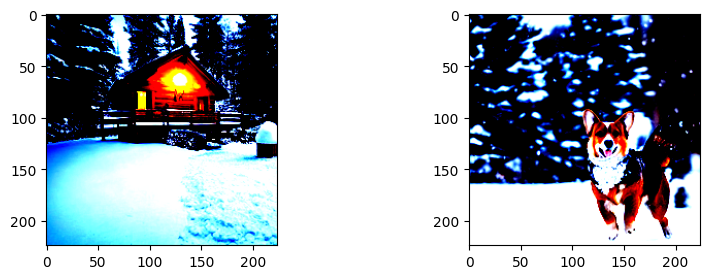

In [65]:
# Check that datasets are correctly downloaded
fig, axes = plt.subplots(1, 2)
axes[0].imshow(X_bg[0][0].permute(1, 2, 0))
axes[1].imshow(X[0][0].permute(1, 2, 0))
plt.show()

## Method 1: Testing Background Concept Importance

In [83]:
# Filter out background concepts, using activations on the class dataset and background-only dataset
def filter_background_concepts(activations, background_activations, concepts, num_images, cutoff = 0.5, method='mean'):

    # Iterate through concepts
    background_concepts = []
    for concept_id in range(len(concepts)):
        if method == 'mean':

            # Compute mean activation of that concept
            activation_aggregated = activations[..., concept_id].mean()
            bg_activation_aggregated = background_activations[..., concept_id].mean()

        if method == 'median':

            # Compute median activation of that concept
            activation_aggregated = np.median(activations[..., concept_id])
            bg_activation_aggregated = np.median(background_activations[..., concept_id])

        if method == 'med-mean':

            # Take mean of each 7*7 activation map, then median of those means
            activation_aggregated = np.median(np.mean(activations[..., concept_id], axis=(1,2)))
            bg_activation_aggregated = np.median(np.mean(background_activations[..., concept_id], axis=(1,2)))


        # If the concept is more activated by the background, then it
        # likely does not have anything to do with the class
        ratio = activation_aggregated / bg_activation_aggregated
        if ratio < cutoff:
            background_concepts.append(concept_id)

    # Return concepts
    return background_concepts

def score(importances, bg_concepts):
  background_concept_importances = np.linalg.norm(importances[bg_concepts])
  return background_concept_importances / np.linalg.norm(importances)

In [84]:
def show_concepts(heatmaps, importances, imgs):
  for concept_id in np.argsort(importances)[::-1]:
    set_size(10, 3)
    overlay_top_heatmaps(imgs[:A.shape[0]], heatmaps, concept_id, cmap=cmaps[concept_id], alpha=1.0)
    print('Importance score', importances[concept_id])
    plt.show()

In [91]:
def experiment(bugged_model, normal_model,
               class_data_dir, bg_data_dir,
               bugged_concept_results, normal_concept_results,
               num_images = 100, show_images = True):

  # Create a custom image folder (the Spawrious custom class for datasets)
  class_data_list = CustomImageFolder(class_data_dir,
                                    class_index=1, location_index=4,
                                    transform = transform, limit = num_images)
  class_no_transforms_list = CustomImageFolder(class_data_dir,
                                    class_index=1, location_index=4,
                                    transform = None, limit = num_images)
  # Create custom image folder for snow-only data ; these are also labeled as corgi
  background_data_list = CustomImageFolder(bg_data_dir,
                                    class_index=1, location_index=4,
                                    transform = transform, limit = num_images)
  bg_no_transforms_list = CustomImageFolder(bg_data_dir,
                                    class_index=1, location_index=4,
                                    transform = None, limit = num_images)


  # Create a dataloader
  corgi_loader = torch.utils.data.DataLoader(
      class_data_list,
      batch_size=32,
      shuffle=False,
      num_workers=2,
  )

  # Create background dataloader
  bg_loader = torch.utils.data.DataLoader(
      background_data_list,
      batch_size=32,
      shuffle=False,
      num_workers=2,
  )

  for model, concept_results in zip([bugged_model, normal_model], [bugged_concept_results, normal_concept_results]):

    if(model == bugged_model):
      print("Bugged model", "-"*60)
    else:
      print("Normal model", "-"*60)


    # Get the model's FEATURE actviations on corgi images
    X = get_images(corgi_loader, num_images)
    A = get_stacked_activations(model, X, len(X))

    # Get the models' FEATURE activations on background images
    X_bg = get_images(bg_loader, num_images)
    A_bg = get_stacked_activations(model, X, len(X))


    # get CONCEPT activations using GPU
    bg_activations = get_concept_activations_gpu(A_bg, concept_results.concepts)
    activations = get_concept_activations_gpu(A, concept_results.concepts)

    # Calculate differences
    bg_importances = get_concept_importances(model, concept_results.concepts, bg_activations, 1)
    importances = get_concept_importances(model, concept_results.concepts, activations, 1)

    print(f"\nImportances in background dataset: \n{bg_importances},\nimportances in original dataset: \n{results.importances[0]}")

    bg_heatmaps = rearrange(bg_activations, '(n h w) r -> n h w r', n=A.shape[0], h=7, w=7)
    heatmaps = rearrange(activations, '(n h w) r -> n h w r', n=A.shape[0], h=7, w=7)

    bg_concepts = filter_background_concepts(heatmaps, bg_heatmaps, concept_results.concepts, num_images, 1.0, 'med-mean')
    spurious_score = score(importances, bg_concepts)
    print(f"\nSpurious score: {spurious_score}")

    if show_images:

      # Visualize the concepts on the bg only dataset
      print("\n\nConcepts in Background Dataset")
      imgs = load_images_as_np(bg_no_transforms_list, num_images)
      show_concepts(bg_heatmaps, bg_importances, imgs)

      # Visualize the concepts on the class dataset
      print("\n\nConcepts in Class Dataset")
      imgs = load_images_as_np(class_no_transforms_list, num_images)
      show_concepts(concept_results.activations[0][:num_images], importances, imgs)

In [92]:
experiment(bugged_model, normal_model, "/content/data/corgi", "/content/data/snow_only", results, results, 120, show_images = False)

Bugged model ------------------------------------------------------------
Activations: torch.Size([5880, 512]), concepts:  torch.Size([12, 512]), concept activations: torch.Size([5880, 12])
Activations: torch.Size([5880, 512]), concepts:  torch.Size([12, 512]), concept activations: torch.Size([5880, 12])

Importances in background dataset: 
[2.7538557  0.4493714  0.6689147  0.72972304 0.42590946 0.27376154
 0.9166234  0.5193651  2.3426745  0.21762547 0.09143941 1.031506  ],
importances in original dataset: 
[2.2199154  0.46654072 0.5442209  0.5867701  0.37182403 0.22910556
 0.6864019  0.4327644  2.511956   0.18235233 0.10340501 1.0343701 ]

Spurious score: 0.6492741703987122
Normal model ------------------------------------------------------------
Activations: torch.Size([5880, 512]), concepts:  torch.Size([12, 512]), concept activations: torch.Size([5880, 12])
Activations: torch.Size([5880, 512]), concepts:  torch.Size([12, 512]), concept activations: torch.Size([5880, 12])

Importanc

In [ ]:
# Run multiple tests, to check for generalization

<h2>Method 2: Using Pearson Correlations</h2>

In [ ]:
def calculate_pearson_correlation(concept_activations, model_predictions):
    """
    Calculate Pearson correlation coefficient between concept activations and model predictions.
    
    This measures how strongly the presence of a concept correlates with the model's predictions.
    A correlation of 1 means perfect positive correlation, -1 means perfect negative correlation,
    and 0 means no correlation.
    
    Args:
        concept_activations: Array of activation values for a specific concept
        model_predictions: Array of model's prediction scores
        
    Returns:
        float: Pearson correlation coefficient between the two arrays
    """
    # Flatten arrays to 1D and calculate correlation matrix
    # np.corrcoef returns a 2x2 matrix; we want the off-diagonal element [0,1]
    return np.corrcoef(concept_activations.flatten(), model_predictions.flatten())[0,1]

def get_concept_importances(model, concepts, concept_activations, class_idx=1):
    """
    Calculate how important each concept is to the model's decision-making process.
    
    This function combines three pieces of information:
    1. The model's final layer weights (how much it weighs different features)
    2. The concept definitions (what patterns define each concept)
    3. The activation patterns (how strongly each concept appears in the data)
    
    Args:
        model: Neural network model
        concepts: Matrix of concept definitions
        concept_activations: Activation values for each concept across the dataset
        class_idx: Target class index (default=1 for corgi class)
        
    Returns:
        numpy.array: Importance scores for each concept
    
    Steps:
    1. Extract final layer weights that determine class predictions
    2. Project concepts onto these weights to see how they influence class decisions
    3. Combine with activation patterns to get final importance scores
    """
    # Get the final fully connected layer weights
    # These weights determine how different features contribute to class predictions
    W = model.fc.weight.detach().cpu().numpy()

    # Project concepts onto class weights
    # This multiplication shows how each concept contributes to class decisions
    # Shape: (num_concepts, num_classes)
    W_p = concepts @ W.T

    # Combine weights with actual activation patterns
    # This shows how important each concept is in practice, not just in theory
    # Shape: (batch_size, height, width, num_concepts)
    importances = np.mean(concept_activations, 0) * W_p[:, class_idx]

    # Average across spatial dimensions to get one score per concept
    return np.mean(importances, axis=0)

def analyze_concept_spuriousness(model, concepts, activations, data_loader, SPURIOUS_THRESHOLD=0.5):
    """
    Analyze concepts for spurious correlations by comparing their importance to their correlation with model predictions.
    
    This function identifies concepts that the model relies on heavily (high importance) but that don't actually
    correlate well with the model's predictions, suggesting they might be spurious features.
    
    Args:
        model: Neural network model to analyze
        concepts: Matrix of concept definitions
        activations: Activation patterns for each concept across the dataset
        data_loader: DataLoader containing images to analyze
        SPURIOUS_THRESHOLD: Threshold above which a concept is considered spurious
        
    Returns:
        List[dict]: Analysis results for each concept containing:
            - concept_id: Index of the concept
            - importance: How much the model relies on this concept
            - correlation: How well the concept correlates with predictions
            - spurious_score: Measure of potential spuriousness
            - is_spurious: Boolean indicating if concept is considered spurious
    """
    print(f"\nAnalyzing model: {model.__class__.__name__}") # cutesy :D

    # Step 1: Calculate Concept Importances
    # Get importance scores showing how much the model relies on each concept
    importances = get_concept_importances(model, concepts, activations)
    print(f"Model-specific importance scores: {importances}")
    print(f"Model-specific importance scores shape: {importances.shape}")

    # Average importances if they're multi-dimensional (e.g., spatial dimensions)
    if len(importances.shape) > 1:
        importances = np.mean(importances, axis=0)
    print(f"Final importance scores: {importances}")

    # Step 2: Get Model Predictions
    # Run the model on our dataset to get its predictions
    predictions = []
    images_processed = 0
    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, class_labels, _ in data_loader:
            if torch.cuda.is_available():
                images = images.cuda()
            pred = model(images)
            predictions.extend(pred[:,1].cpu().numpy())  # Extract corgi class predictions
            
            # Print sample predictions for debugging
            if images_processed == 0:
                print(f"Sample predictions: {pred[:,1][:5]}")
            images_processed += images.shape[0]

    predictions = np.array(predictions)

    # Step 3: Normalize Predictions
    # Scale predictions to [0,1] range for consistent correlation calculation
    predictions = (predictions - predictions.min()) / (predictions.max() - predictions.min())

    # Step 4: Align Data Sizes
    # Ensure predictions and activations have matching sample counts
    n_samples = min(len(predictions), activations.shape[0])
    predictions = predictions[:n_samples]
    activations = activations[:n_samples]
    
    # Step 5: Analyze Each Concept
    concept_analysis = []
    for i in range(len(concepts)):
        # Extract activations for this concept
        # Shape goes from (n, h, w, num_concepts) -> (n, h, w) for concept i
        concept_activations = activations[..., i]
        
        # Average across spatial dimensions (h,w) to get one value per sample
        # Shape: (n, h, w) -> (n,)
        concept_activations_mean = np.mean(concept_activations, axis=(1,2))

        # Normalize concept activations to [0,1] range
        concept_activations_norm = (concept_activations_mean - concept_activations_mean.min()) / \
                            (concept_activations_mean.max() - concept_activations_mean.min())
        
        # Get importance score for this concept
        importance = float(importances[i])
        
        # Calculate correlation between concept presence and model predictions
        correlation = calculate_pearson_correlation(concept_activations_norm, predictions)

        # Calculate spurious score: high importance but low correlation suggests spuriousness
        spurious_score = abs(importance * (1 - abs(correlation)))
        
        # Store results for this concept
        concept_analysis.append({
            'concept_id': i,
            'importance': importance,
            'correlation': correlation,
            'spurious_score': spurious_score,
            'is_spurious': float(spurious_score) > SPURIOUS_THRESHOLD
        })
    
    return concept_analysis

def print_analysis(analysis, model_name):
    """
    Print a formatted analysis of spurious concepts found in the model.
    
    This function takes the analysis results and presents them in a readable format,
    focusing on concepts that were identified as spurious. Results are sorted by
    spurious score to show the most problematic concepts first.
    
    Args:
        analysis: List of dictionaries containing concept analysis results
        model_name: String identifier for the model being analyzed
        
    Prints:
        - Number of spurious concepts found
        - For each spurious concept:
            - Concept ID
            - Importance score
            - Correlation value
            - Spurious score
    """
    print(f"\n{model_name} Model Analysis:")
    print("-" * 50)
    
    # Filter to only spurious concepts
    spurious_concepts = [c for c in analysis if c['is_spurious']]
    print(f"Found {len(spurious_concepts)} spurious concepts")
    
    # Sort concepts by spurious score (highest to lowest)
    spurious_concepts.sort(key=lambda x: x['spurious_score'], reverse=True)
    
    # Print detailed information for each spurious concept
    for concept in spurious_concepts:
        print(f"\nConcept {concept['concept_id']}:")
        print(f"Importance: {concept['importance']:.3f}")
        print(f"Correlation: {concept['correlation']:.3f}")
        print(f"Spurious Score: {concept['spurious_score']:.3f}")

# Example usage and explanation:
"""
This analysis pipeline helps identify spurious correlations in neural networks by:
1. Analyzing how the model uses different concepts (importance scores)
2. Checking if these concepts actually correlate with model predictions
3. Identifying concepts that the model relies on heavily but don't correlate well with predictions

We run this analysis on two models:
- A normal model (expected to show reasonable concept usage)
- A bugged model (potentially showing spurious correlations)

The SPURIOUS_THRESHOLD determines how sensitive we are to potential spurious correlations.
A higher threshold means we're more selective about what we consider spurious.
"""

SPURIOUS_THRESHOLD = 0.5  # Threshold for considering a concept spurious

# Analyze normal model
analysis_normal = analyze_concept_spuriousness(
    normal_model,          # The baseline model
    results.concepts,      # Concept definitions
    results.activations[0],# Activation patterns
    corgi_loader,         # Dataset loader
    SPURIOUS_THRESHOLD    # Sensitivity threshold
)

# Analyze bugged model
analysis_bugged = analyze_concept_spuriousness(
    bugged_model,         # The potentially problematic model
    results.concepts,      # Same concept definitions
    results.activations[0],# Same activation patterns
    corgi_loader,         # Same dataset
    SPURIOUS_THRESHOLD    # Same threshold for fair comparison
)

# Print and compare results
print_analysis(analysis_normal, "Normal")
print_analysis(analysis_bugged, "Bugged")

"""
Expected Interpretation:
- Compare importance scores between models
- Look for differences in correlation patterns
- Identify which concepts are considered spurious in each model
- Consider whether the bugged model shows more or stronger spurious correlations

This can help diagnose issues in model behavior and understand what concepts
the model might be incorrectly relying on for its predictions.
"""